# 1.1 Проверка пропусков и выбросов

Проверим пропуски

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('insurance.csv')

print("Пропуски в данных:")
print(df.isnull().sum())
print()

num = df.select_dtypes(include=[np.number])
for col in num.columns:
    Q1 = num[col].quantile(0.25)
    Q3 = num[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = ((num[col] < lower) | (num[col] > upper)).sum()
    if n_out > 0:
        print(f"Выбросы в {col}: {n_out} из {len(df)}")


print("\nОсновные статистики:")
print(df.describe())

Пропуски в данных:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Выбросы в bmi: 9 из 1338
Выбросы в charges: 139 из 1338

Основные статистики:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


# 1.2 Преобразование категориальных признаков
Пол и курильвщик - бинарные данные, регион - номинальный

In [8]:
categorical_columns = ['sex', 'smoker', 'region']

df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})

df_encoded = pd.get_dummies(df_encoded, columns=['region'], prefix='region')

print("\nПреобразованные данные:")
print(df_encoded.head())
print(f"Размерность после кодирования: {df_encoded.shape}")



Преобразованные данные:
   age  sex     bmi  children  smoker      charges  region_northeast  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061             False   
4   32    1  28.880         0       0   3866.85520             False   

   region_northwest  region_southeast  region_southwest  
0             False             False              True  
1             False              True             False  
2             False              True             False  
3              True             False             False  
4              True             False             False  
Размерность после кодирования: (1338, 10)


# 1.3 Парные корреляции

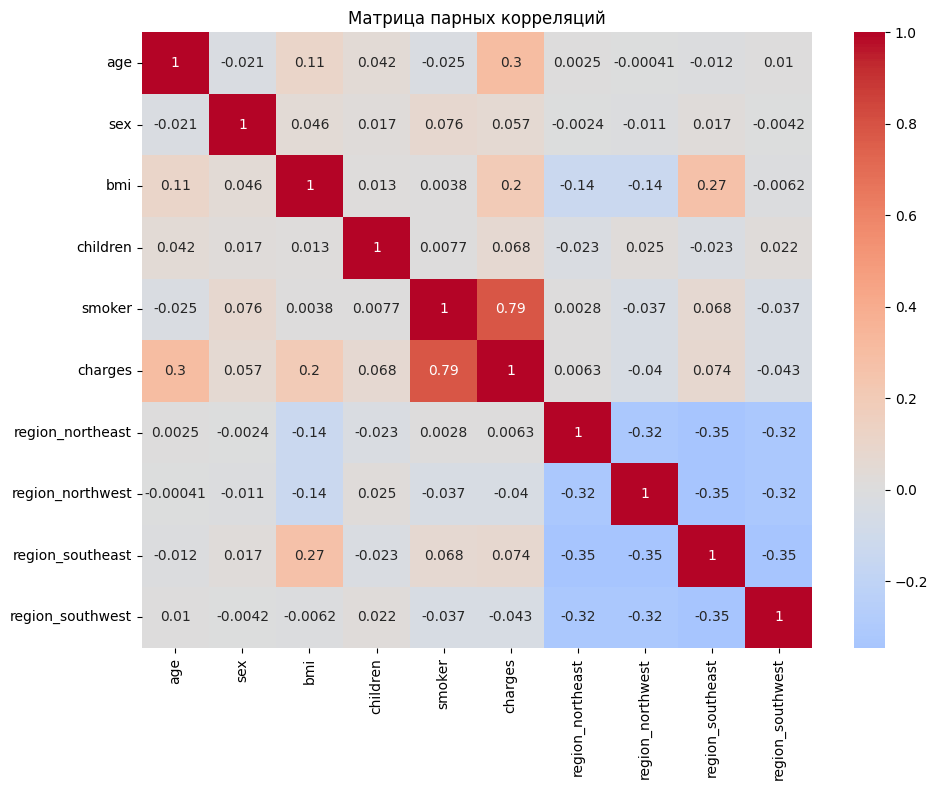

In [10]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица парных корреляций')
plt.tight_layout()
plt.show()

Можно предположить что сильную прямую корелляцию имеют только smoker и charges

# 2. Многомерная линейная регрессия
# 2.1 Аналитическое решение
Аналитическое решение через нормальное уравнение: w = (X^T * X)^(-1) * X^T * y
Также реализация Градиентного спуска.

In [42]:
class LinearRegression:
    def __init__(self):
        self.w = None
    
    def fit_analytical(self, X, y):
        X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
        
        try:
            self.w = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
        except np.linalg.LinAlgError:
            self.w = np.linalg.pinv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
        
        return self.w
    
    def predict(self, X):
        X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
        return X_with_intercept @ self.w
    def fit_gradient_descent(self, X, y, learning_rate=0.001, max_iter=1000, tol=1e-6):
        X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
        n_samples, n_features = X_with_intercept.shape
        
        self.w = np.zeros(n_features)
        
        errors = []
        
        for i in range(max_iter):
            y_pred = X_with_intercept @ self.w
            
            error = y_pred - y
            mse = np.mean(error ** 2)
            errors.append(mse)
            
            gradient = (2 / n_samples) * X_with_intercept.T @ error
            
            self.w -= learning_rate * gradient
            
            if i > 0 and abs(errors[-1] - errors[-2]) < tol:
                print(f"Градиентный спуск сошелся на итерации {i}")
                break
        
        return self.w, errors

Градиентный спуск

Далее найдем решение аналитическим путем. Для этого потребуется разделить данные на трейновые и тестовые.

In [43]:

X = df_encoded.drop('charges', axis=1).values
y = df_encoded['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()

w_analytical = lr.fit_analytical(X_train_scaled, y_train)
print(w_analytical)

[ 1.33460897e+04  3.61245563e+03 -1.04386062e+01  2.05516950e+03
  5.15192078e+02  9.55849404e+03 -1.01027943e+03 -8.35437348e+02
 -9.25913327e+02 -1.14388433e+03]


Градиентный спуск с визуализацией сходимости

Градиентный спуск сошелся на итерации 790
[ 1.33460882e+04  3.61497461e+03 -9.29083849e+00  2.03622581e+03
  5.16891358e+02  9.55847800e+03  1.99697469e+02  3.87340853e+01
 -8.66196652e+01 -1.50167171e+02]


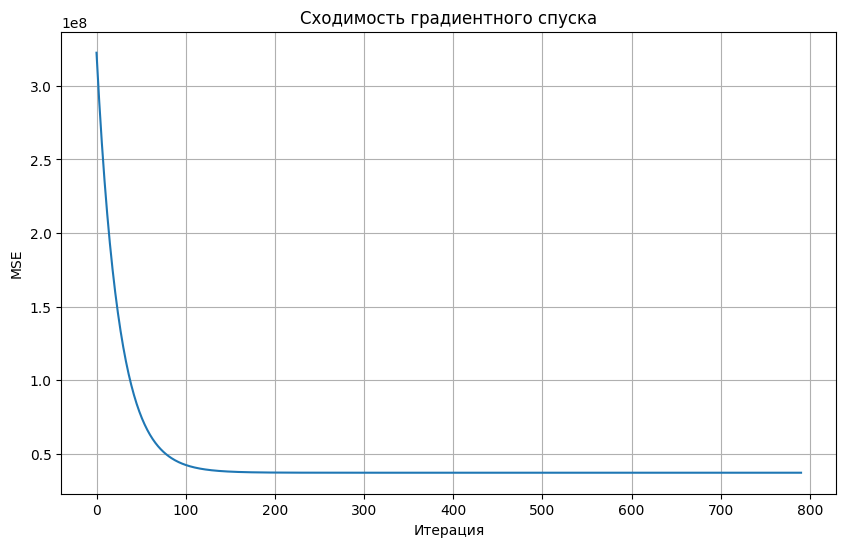

In [44]:

w_gd, errors = lr.fit_gradient_descent(X_train_scaled, y_train, learning_rate=0.01, max_iter=5000)
print(w_gd)

plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.title('Сходимость градиентного спуска')
plt.grid(True)
plt.show()

# 3 Регрессия
# 3.1 Гребневая регрессия (аналитическое решение)

Решение: w = (X^T * X + alpha * I)^(-1) * X^T * y

In [57]:
def fit_ridge_analytical(X, y, alpha=1.0):
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    n_features = X_with_intercept.shape[1]

    w = None
    try:
        w = np.linalg.inv(X_with_intercept.T @ X_with_intercept + alpha * np.eye(n_features)) @ X_with_intercept.T @ y
    except np.linalg.LinAlgError:
        w = np.linalg.pinv(X_with_intercept.T @ X_with_intercept + alpha * np.eye(n_features)) @ X_with_intercept.T @ y
        
    return w

w_ridge_analytical = fit_ridge_analytical(X_train_scaled, y_train, alpha=0.1)
print(w_ridge_analytical)

[ 1.33448426e+04  3.61461298e+03 -9.22571134e+00  2.03605038e+03
  5.16877690e+02  9.55755963e+03  1.99666465e+02  3.86990544e+01
 -8.65513321e+01 -1.50171293e+02]


# 3.2 Гребневая регрессия (градиентный спуск)
Градиент с L2 регуляризацией

Гребневая регрессия сошлась на итерации 9008
[ 1.21328088e+04  3.26477080e+03  5.01820664e+01  1.86336554e+03
  5.01271261e+02  8.66512421e+03  1.69834195e+02  6.21260940e+00
 -2.30377160e+01 -1.53056813e+02]

Сравнение весов моделей:
            Feature  Linear (Analytical)   Linear (GD)  Ridge (Analytical)  \
0         intercept         13346.089736  13346.088205        13344.842555   
1               age          3612.455626   3614.974606         3614.612984   
2               sex           -10.438606     -9.290838           -9.225711   
3               bmi          2055.169504   2036.225815         2036.050385   
4          children           515.192078    516.891358          516.877690   
5            smoker          9558.494038   9558.477997         9557.559629   
6  region_northeast         -1010.279427    199.697469          199.666465   
7  region_northwest          -835.437348     38.734085           38.699054   
8  region_southeast          -925.913327    -86.619665         

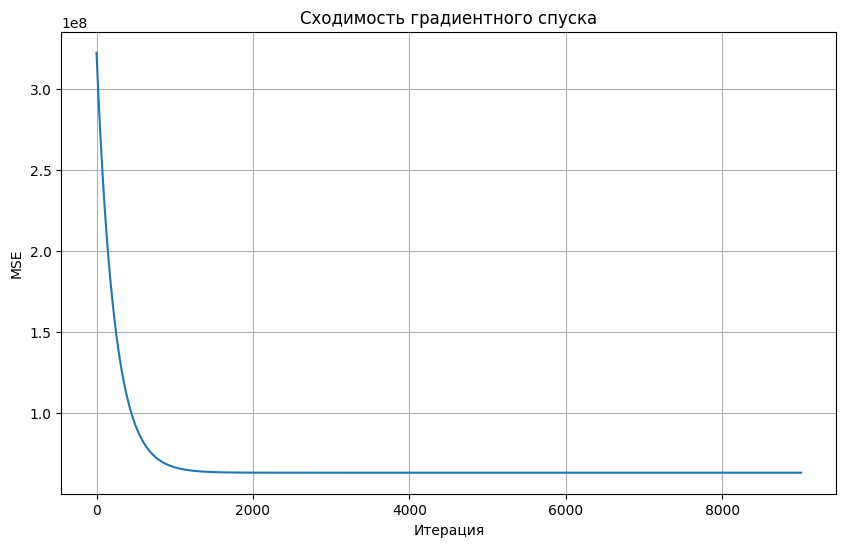

In [60]:
    
def fit_ridge_gradient(X, y, alpha=1.0, learning_rate=0.001, max_iter=10000):
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    n_samples, n_features = X_with_intercept.shape
    
    w = np.zeros(n_features)
    errors = []
    
    for i in range(max_iter):
        y_pred = X_with_intercept @ w
        error = y_pred - y
        
        gradient = (2 / n_samples) * X_with_intercept.T @ error + 2 * alpha * w
        
        w -= learning_rate * gradient
        
        mse = np.mean(error ** 2) + alpha * np.sum(w ** 2)
        errors.append(mse)
        
        if i > 0 and abs(errors[-1] - errors[-2]) < 1e-6:
            print(f"Гребневая регрессия сошлась на итерации {i}")
            break
    
    return w, errors

def predict(w, X):
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    return X_with_intercept @ w


w_ridge_gd, ridge_errors = fit_ridge_gradient(X_train_scaled, y_train, alpha=0.1)
print(w_ridge_gd)

feature_names = ['intercept'] + list(df_encoded.drop('charges', axis=1).columns)

print("\nСравнение весов моделей:")
weights_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Linear (Analytical)': w_analytical,
    'Linear (GD)': w_gd,
    'Ridge (Analytical)': w_ridge_analytical,
    'Ridge (GD)': w_ridge_gd,
})
print(weights_comparison)

plt.figure(figsize=(10, 6))
plt.plot(ridge_errors)
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.title('Сходимость градиентного спуска')
plt.grid(True)
plt.show()

# 4. Оценка обобщающей способности
для начала напишу функции нахождения среднеквадратической ошибки (mse) и R^2

In [66]:
def calc_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)



# 4.1 Константная модель (прогноз средним значением)

In [72]:
predictions = {}

constant_pred = np.full_like(y_test, np.mean(y_train))
predictions['Constant (Mean)'] = constant_pred

# 4.2 модели из пункта 2 
многомерные линейные модели построенные аналитически и градиентным спуском

In [73]:
predictions['Linear Regression (Analytical)'] = predict(w_analytical, X_test_scaled)
predictions['Linear (GD)'] = predict(w_gd, X_test_scaled)

# 4.3 модели из пункта 3
модели Гребневой регрессии построенные аналитически и градиентным спуском

In [74]:
predictions['Ridge (Analytical)'] = predict(w_ridge_analytical, X_test_scaled)
predictions['Ridge (GD)'] = predict(w_ridge_gd, X_test_scaled)

In [75]:
results = []
for model_name, y_pred in predictions.items():
    mse = calc_mse(y_test, y_pred)
    r2 = calc_r2(y_test, y_pred)
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R^2': r2
    })

results_df = pd.DataFrame(results)
print("\nСравнение моделей на тестовой выборке:")
print(results_df)


Сравнение моделей на тестовой выборке:
                            Model           MSE          RMSE       R^2
0                 Constant (Mean)  1.553914e+08  12465.610442 -0.000919
1  Linear Regression (Analytical)  3.403720e+07   5834.140536  0.780757
2                     Linear (GD)  3.359692e+07   5796.285049  0.783593
3              Ridge (Analytical)  3.359713e+07   5796.302843  0.783592
4                      Ridge (GD)  3.620043e+07   6016.679353  0.766823


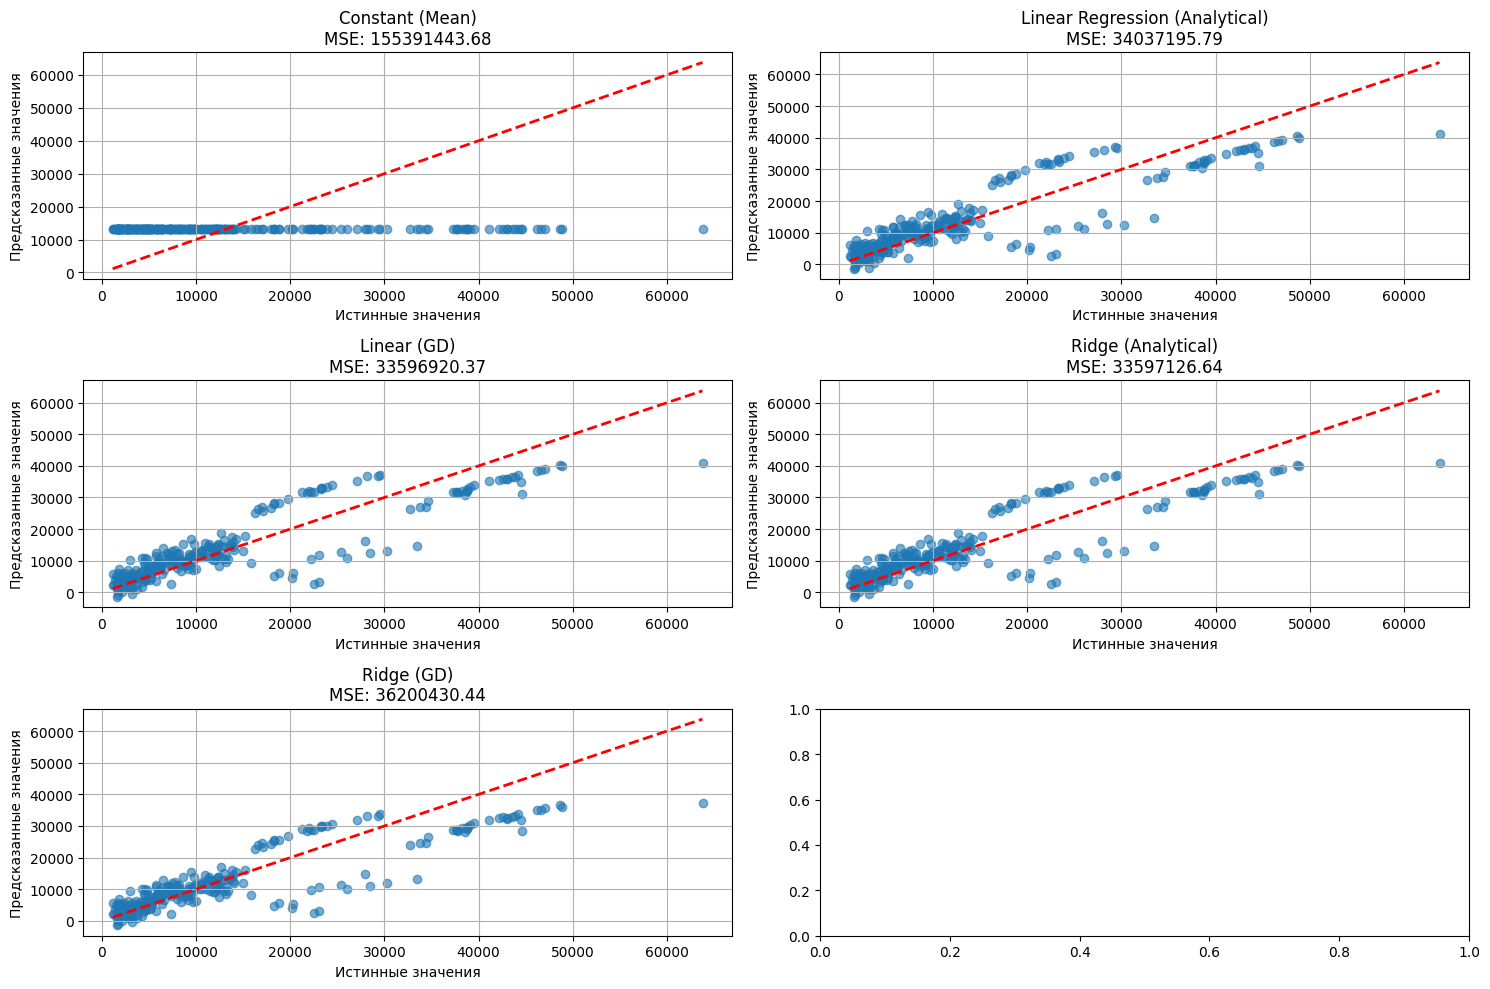

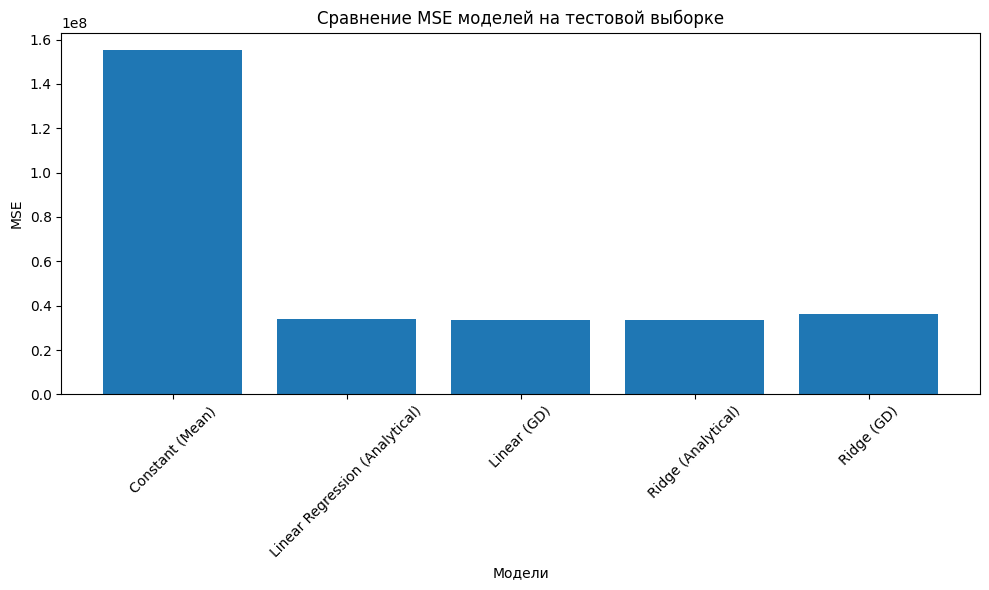


Лучшая модель: Linear (GD) с MSE = 33596920.37


In [76]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (model_name, y_pred) in enumerate(predictions.items()):
    axes[i].scatter(y_test, y_pred, alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Истинные значения')
    axes[i].set_ylabel('Предсказанные значения')
    axes[i].set_title(f'{model_name}\nMSE: {calc_mse(y_test, y_pred):.2f}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
models_list = [r['Model'] for r in results]
mse_values = [r['MSE'] for r in results]

plt.bar(models_list, mse_values)
plt.xlabel('Модели')
plt.ylabel('MSE')
plt.title('Сравнение MSE моделей на тестовой выборке')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

best_model_idx = np.argmin(mse_values[1:]) + 1
print(f"\nЛучшая модель: {models_list[best_model_idx]} с MSE = {mse_values[best_model_idx]:.2f}")